In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import scienceplots
import pickle as pkl

In [2]:
# plt.style.use(['science','ieee'])

In [3]:
raw_data = open("data", "r").read()

In [4]:
def parse_data(raw_data, experiment):
  data = raw_data.split("----         STOP         ----")
  data = filter(lambda x: x.find(experiment)!=-1, data)
  data = list(map(lambda x: x.split("\n"), data))
  data = sum(data, [])
  data = filter(lambda x: x.find("simulation")!=-1, data)
  data = map(lambda x: x[x.find(":")+1:-1], data)
  data = list(map(lambda x: float(x), data))
  data = np.array(data)
  data = data.reshape((12, 41))

  return data

In [5]:
class MPIExperiment():
  def __init__(self, filename):
    self.filename = filename
    with open(filename, "rb") as f:
      self.data = pkl.load(f)

  def plot_mpi_strong_scalability(self):
    plt.plot(self.data["nodes"], [np.mean(self.data["t0"]) / np.mean(np.max(t, axis=1)) for t in self.data["el_time_mpi_v2"]], label="MPIv2")
    plt.plot(self.data["nodes"], self.data["nodes"], label="Ideal")
    plt.xlabel("$N$ nodes")
    plt.ylabel("Speedup T($N$)/$N$")
    plt.legend()
    plt.title("Strong Scalability with 65536 bodies")

  def plot_comparison_with_mpi_omp_avx(self, filename):
    with open(filename, "rb") as f:
      self.mpi_omp_avx_data = pkl.load(f)
    nodes = self.mpi_omp_avx_data["nodes"]
    plt.plot(nodes, [np.mean(np.max(t, axis=1)) for t in self.mpi_omp_avx_data["el_time_mpi_avx"]], label="mpi_omp_avx")
    # plt.fill_between(nodes, [np.min(np.max(t, axis=1)) for t in el_time_mpi_avx], [np.max(np.max(t, axis=1)) for t in el_time_mpi_avx])
    plt.plot(nodes, np.array([np.mean(np.max(t, axis=1)) for t in self.data["el_time_mpi_v2"]])[self.mpi_omp_avx_data["idx"]], label="mpiv2")
    # plt.fill_between(nodes, [np.min(np.max(t, axis=1)) for t in el_time_mpi_v2], [np.max(np.max(t, axis=1)) for t in el_time_mpi_v2])
    plt.plot(nodes, np.array([np.mean(np.max(t, axis=1)) for t in self.data["el_time_mpi_v3"]])[self.mpi_omp_avx_data["idx"]], label="mpiv3", alpha=0.6)
    # plt.fill_between(nodes, [np.min(np.max(t, axis=1)) for t in el_time_mpi_v3], [np.max(np.max(t, axis=1)) for t in el_time_mpi_v3])
    plt.yscale("log")
    plt.legend()
    plt.xlabel("$N$ nodes")
    plt.ylabel("Elapsed Time (s)")
    plt.title("Runtime with 65536 bodies");


In [6]:
class GpuExperiment():
  """
  A class representing a GPU experiment.

  Attributes:
    filename (str): The filename of the data file.
    data (numpy.ndarray): The loaded data.

  Methods:
    plot_nvidia_vs_our_regime: Plots the comparison between our solution and Nvidia's solution at regime.
    plt_nvidia_vs_our_fill: Plots the comparison between our solution and Nvidia's solution when filling the gpu cores.
    plot_float_vs_double: Plots the comparison between float and double solutions.
  """

  def __init__(self, filename):
    self.filename = filename
    self.data = np.load(filename)

  def plot_nvidia_vs_our_regime(self):
    """
    Plots the comparison between our solution and Nvidia's solution.

    This method plots the elapsed time of our solution and Nvidia's solution
    for different numbers of bodies.
    """
    plt.plot(self.data["n_bodies_regime"], self.data["mu_our_solution_el_time"][len(self.data["n_bodies_fill"]):], label="OurNbody")
    plt.plot(self.data["n_bodies_regime"], self.data["mu_nvidia_solution_el_time"][len(self.data["n_bodies_fill"]):], label="Nvidia")
    plt.fill_between(self.data["n_bodies_regime"], 
                     self.data["min_our_solution_el_time"][len(self.data["n_bodies_fill"]):], 
                     self.data["max_our_solution_el_time"][len(self.data["n_bodies_fill"]):], alpha=0.2)
    plt.xlabel("$N$ bodies $(10^5)$")
    plt.ylabel("Elapsed Time (s)")
    plt.legend()
    plt.xticks(ticks=self.data["n_bodies_regime"], labels=[f"${i}$" for i in range (1, 10)])
    plt.savefig("runtime_analysis.svg", format="svg")
  
  def plot_nvidia_vs_our_fill(self):
    plt.plot(self.data["n_bodies_fill"], self.data["mu_our_solution_el_time"][:len(self.data["n_bodies_fill"])], label="OurNbody")
    plt.plot(self.data["n_bodies_fill"], self.data["mu_nvidia_solution_el_time"][:len(self.data["n_bodies_fill"])], label="Nvidia")
    plt.fill_between(self.data["n_bodies_fill"], 
                    self.data["min_our_solution_el_time"][:len(self.data["n_bodies_fill"])], 
                    self.data["max_our_solution_el_time"][:len(self.data["n_bodies_fill"])], alpha=0.2)
    plt.xlabel("$N$ bodies")
    plt.ylabel("Elapsed Time (s)")
    plt.xscale("log")
    plt.legend()
    plt.savefig("runtime_analysis.svg", format="svg")

  def plot_float_vs_double(self):
    plt.plot(self.data["t"], self.data["mu_cuda_float_solution"], label="float")
    plt.plot(self.data["t"], self.data["mu_cuda_double_solution"], label="double")
    plt.fill_between(self.data["t"], 
            self.data["min_cuda_float_solution"], 
            self.data["max_cuda_float_solution"], alpha=0.2)
    plt.fill_between(self.data["t"], 
            self.data["min_cuda_double_solution"], 
            self.data["max_cuda_double_solution"], alpha=0.2)
    plt.xlabel("Iteration $t$")
    plt.ylabel("$E_{tot}$")
    plt.legend()

In [7]:
gpu_exp = GpuExperiment(filename="./raw_data/gpu_sim.npz")

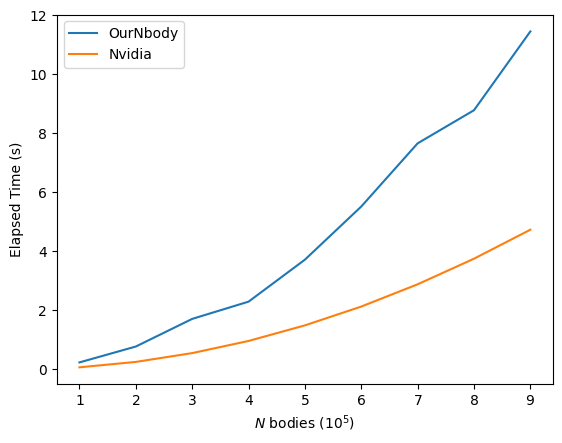

In [8]:
gpu_exp.plot_nvidia_vs_our_regime()

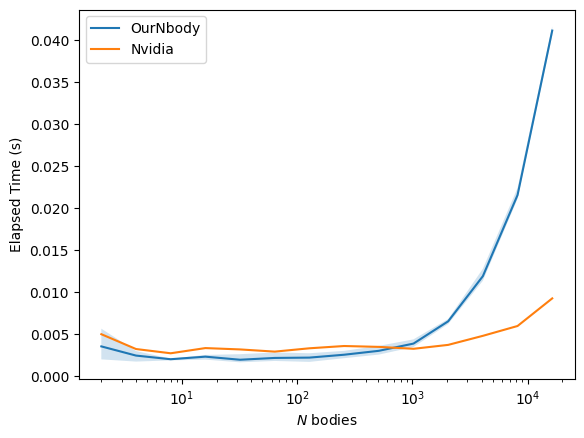

In [9]:
gpu_exp.plot_nvidia_vs_our_fill()

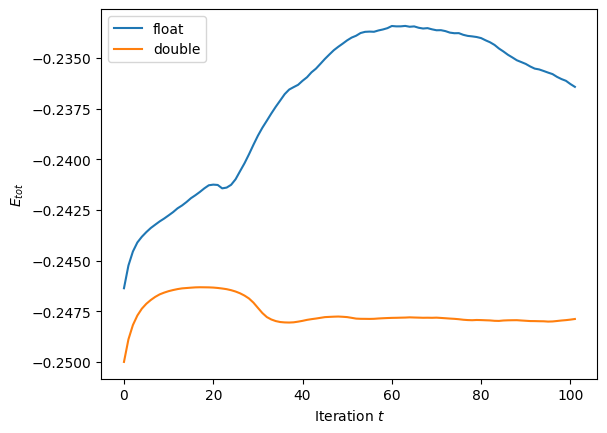

In [10]:
gpu_exp.plot_float_vs_double()

In [11]:
mpi_exp = MPIExperiment(filename="./raw_data/mpi_sim.pkl")

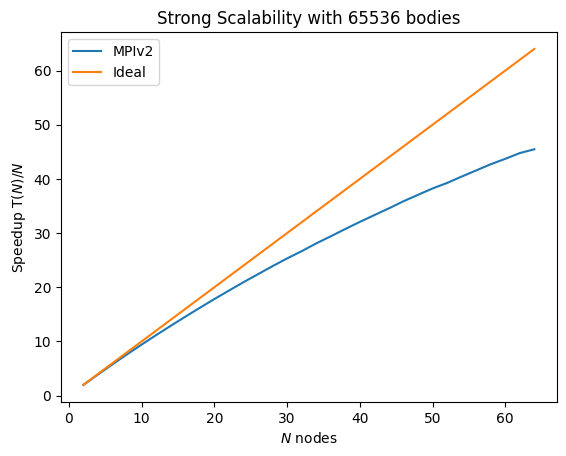

In [12]:
mpi_exp.plot_mpi_strong_scalability()

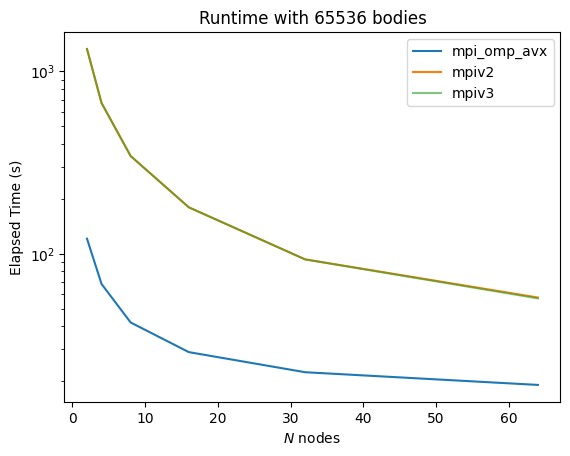

In [13]:
mpi_exp.plot_comparison_with_mpi_omp_avx(filename="./raw_data/mpi_omp_avx_sim.pkl")

In [ ]:
mpi_exp.data["el_time_mpi_v2"]
mpi_exp.data["nodes"]

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64])

In [17]:
def statistical_analysis(data):
  y = np.mean(data, axis=0)
  y_err = np.std(data, axis=0)
  return y, y_err

In [82]:
def plot_data(y, y_err, title):
  x = np.arange(0, 81, 2)
  x[0] = 1
  s_up = np.array(list(map(lambda x: y[0]/x, y)))
  s_up_err = []
  for i in range(len(y)):
    s_up_err.append(np.sqrt((y_err[0]/y[i])**2 + (y[0]/y[i]**2 * y_err[i])**2))
  s_up_err = np.array(s_up_err)
  eff = s_up/x
  eff_err = s_up_err/x
  cost = x*y
  cost_err = x*y_err

  fig, axs = plt.subplots(2,2, figsize=(18, 10))
  fig.subplots_adjust(hspace=0.4)  
  axs[0][0].plot(x, y, '-', label="Runtime")
  axs[0][0].fill_between(x, y-y_err, y+y_err, alpha=0.2)
  axs[0][0].set_ylabel("Time (s)")
  axs[0][0].set_xlabel("Number of threads")
  axs[0][0].set_title("Runtime")
  axs[0][0].grid()
  axs[0][0].legend()

  axs[0][1].plot(x, s_up, '-', label="Speedup")
  axs[0][1].fill_between(x, s_up-s_up_err, s_up+s_up_err, alpha=0.2)
  axs[0][1].set_ylabel("T[0]/T[i]")
  axs[0][1].set_xlabel("Number of threads")
  axs[0][1].set_title("Speedup")
  axs[0][1].grid()
  axs[0][1].legend()

  axs[1][0].plot(x, eff, '-', label="Efficiency")
  axs[1][0].fill_between(x, eff-eff_err, eff+eff_err, alpha=0.2)
  axs[1][0].set_ylabel("T[0]/(T[i]*i)")
  axs[1][0].set_xlabel("Number of threads")
  axs[1][0].set_title("Efficiency")
  axs[1][0].grid()
  axs[1][0].legend()

  axs[1][1].plot(x, cost, '-', label="Cost")
  axs[1][1].fill_between(x, cost-cost_err, cost+cost_err, alpha=0.2)
  axs[1][1].set_ylabel("T[i]*i")
  axs[1][1].set_xlabel("Number of threads")
  axs[1][1].set_title("Cost")
  axs[1][1].grid()
  axs[1][1].legend()
  
  fig.suptitle(title)
  fig.tight_layout()
  plt.show()

In [83]:
def analyze_experiment(raw_data, experiment, title):
  data = parse_data(raw_data, experiment)
  y, y_err = statistical_analysis(data)
  plot_data(y, y_err, title)

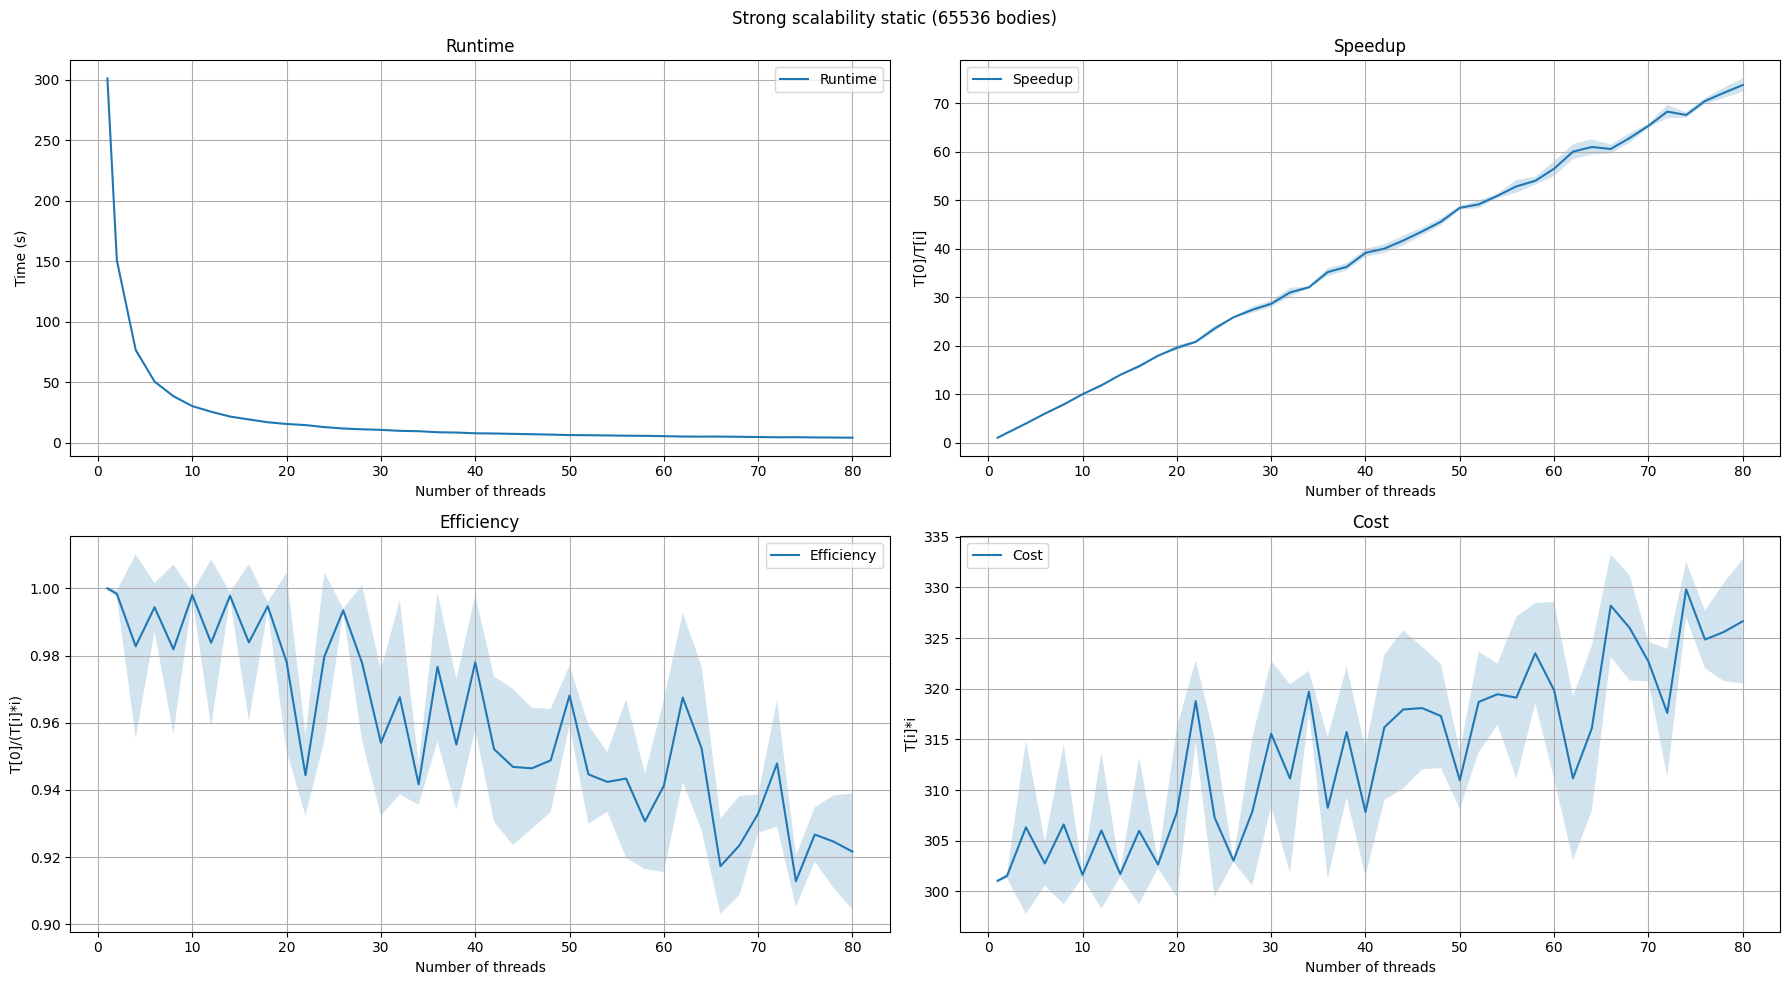

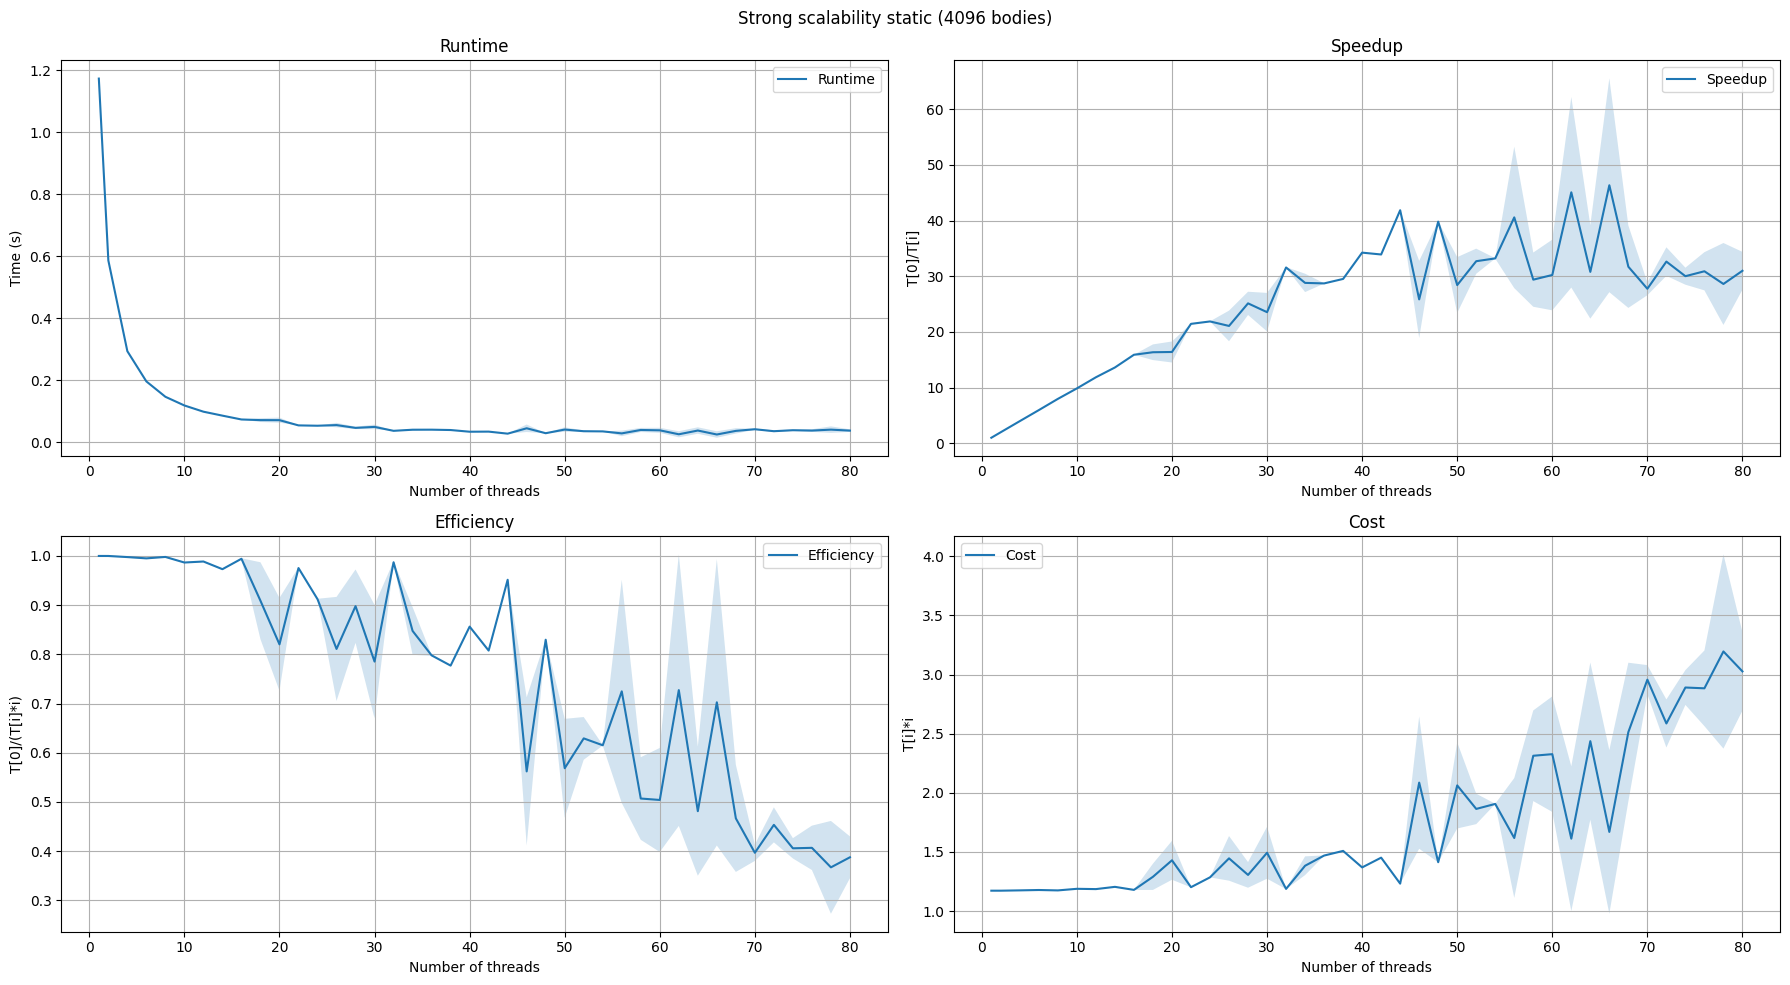

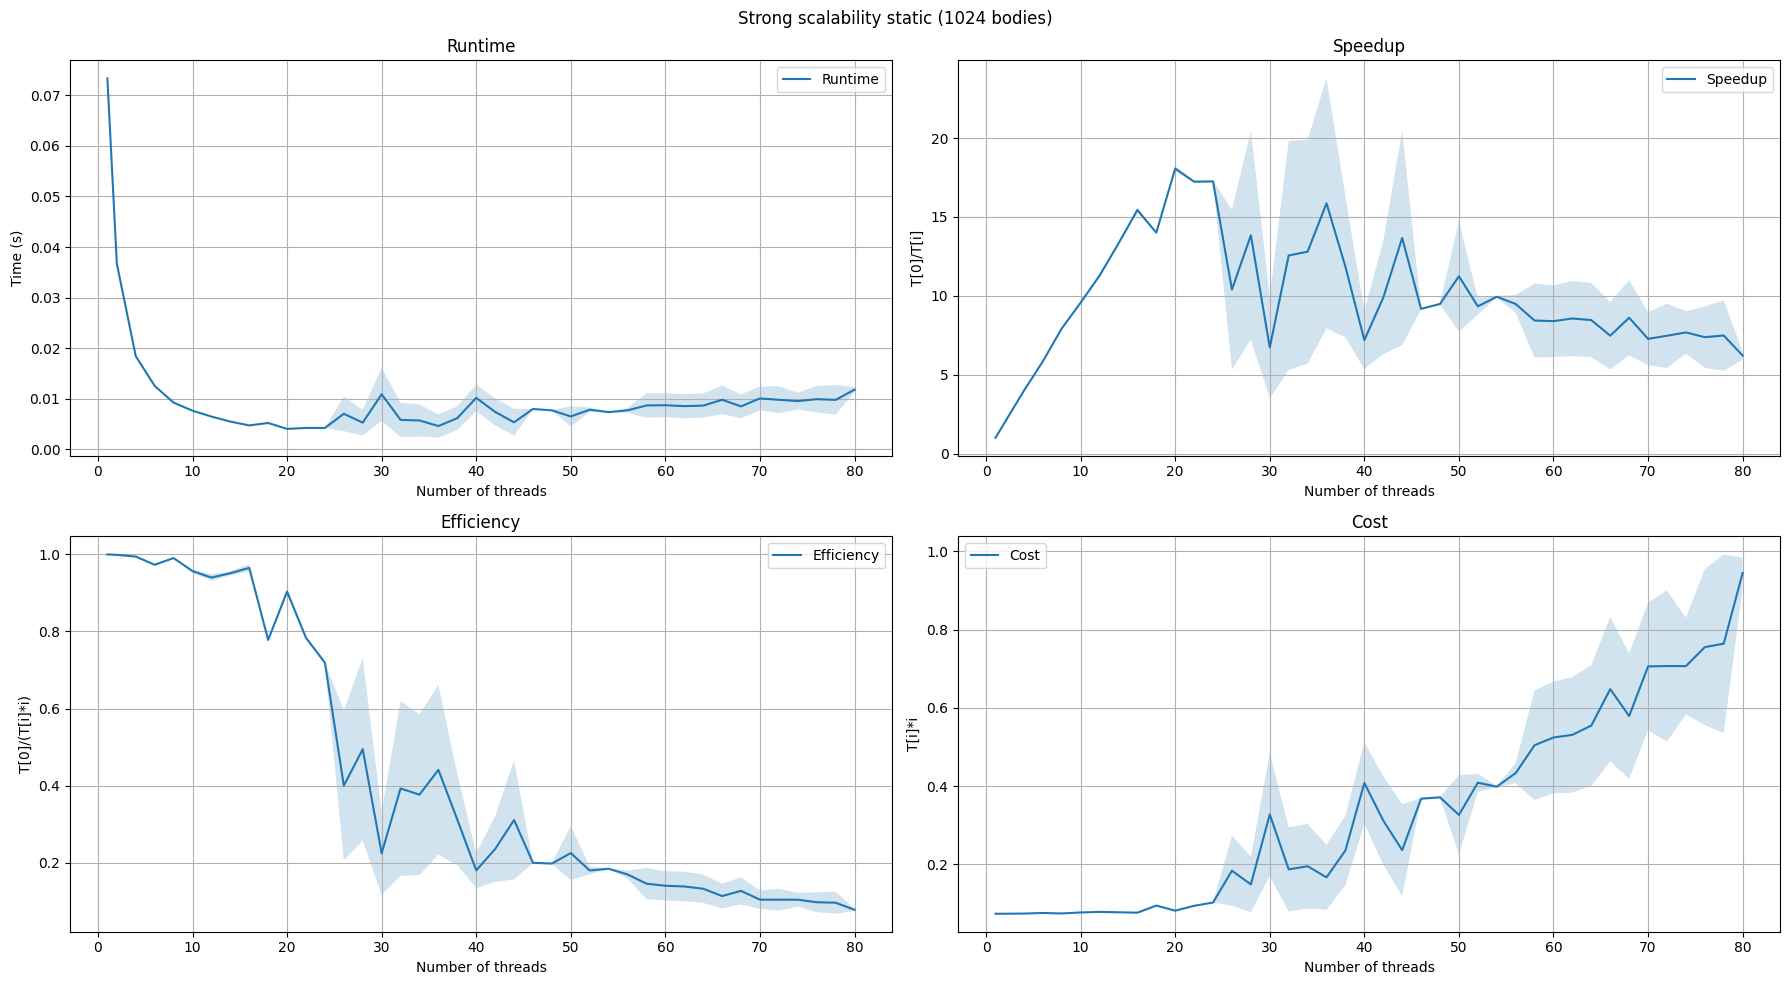

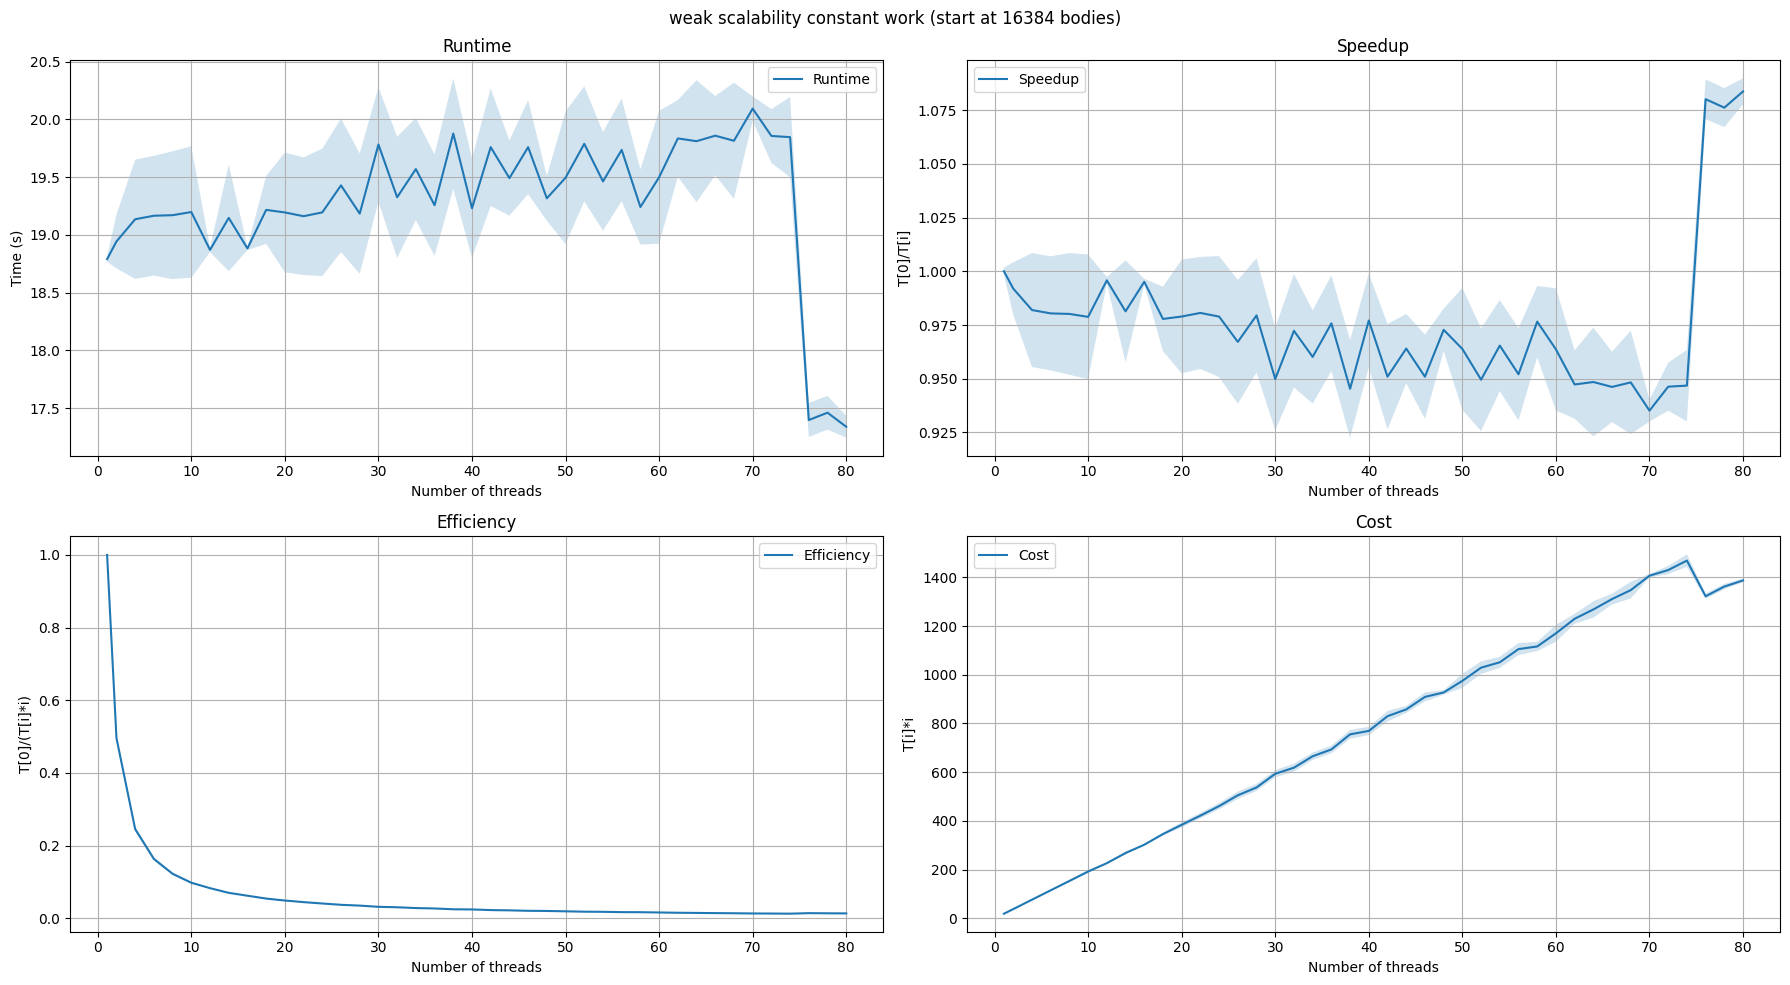

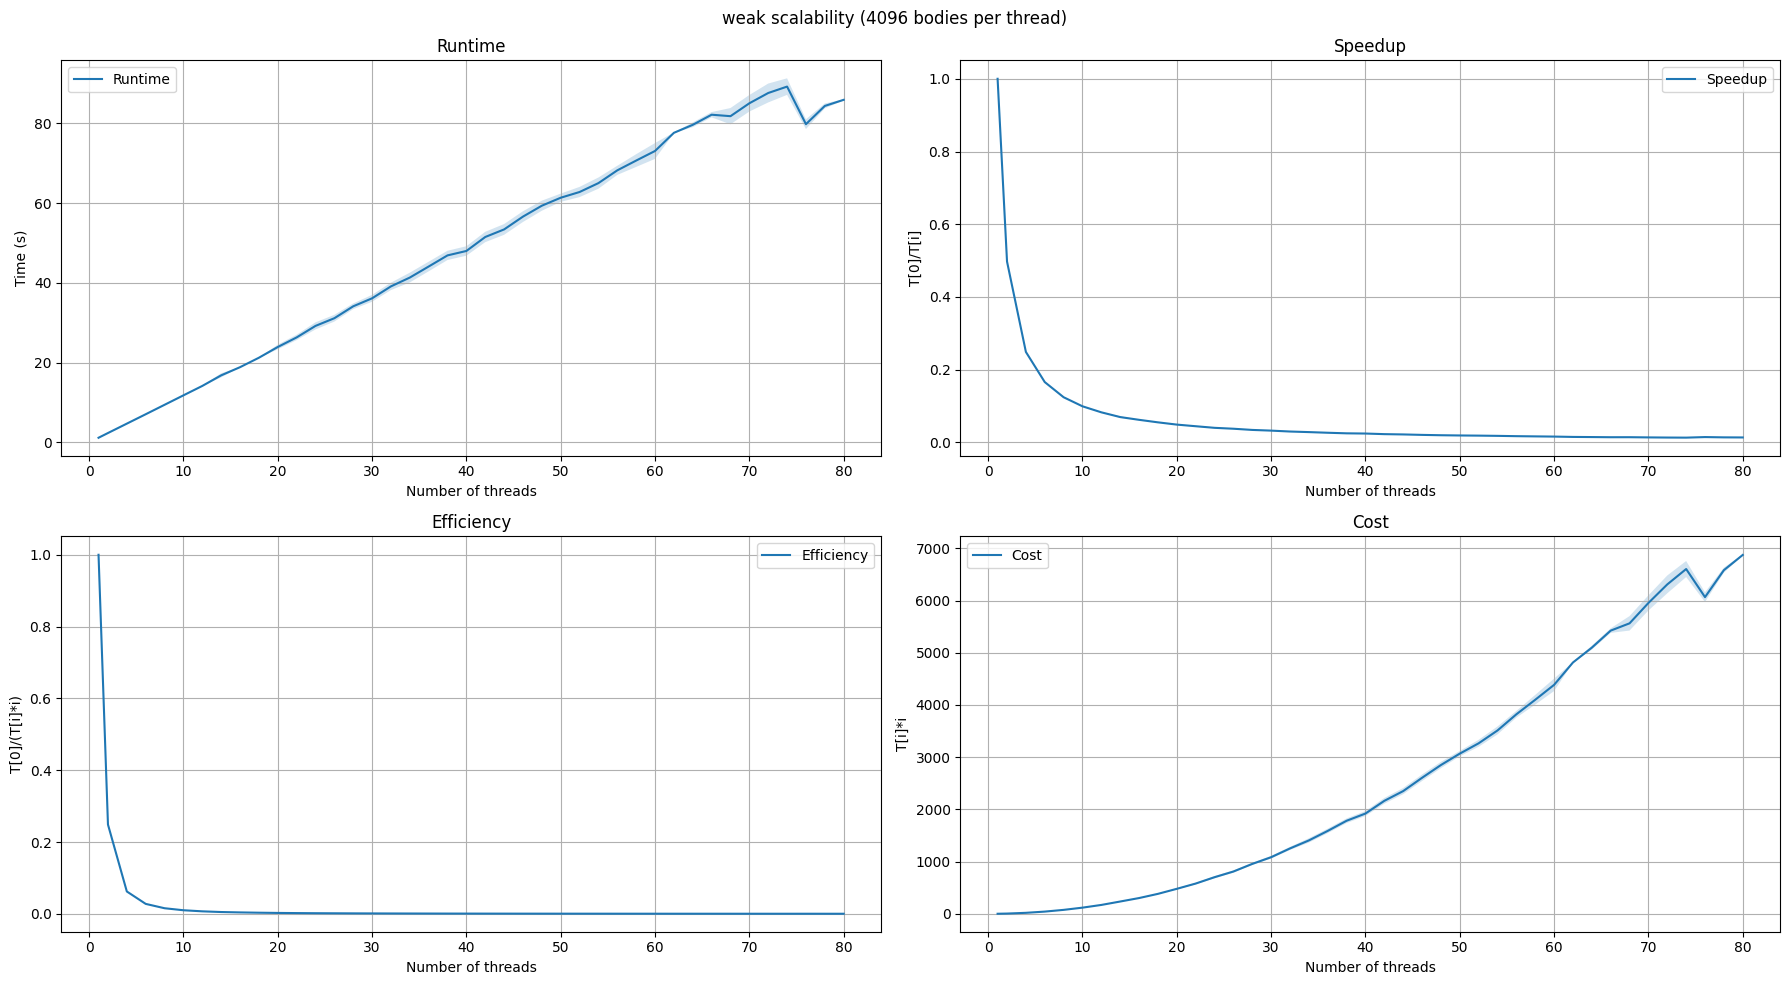

In [84]:
analyze_experiment(raw_data, "strong scalability static 65536", "Strong scalability static (65536 bodies)")
analyze_experiment(raw_data, "strong scalability static 4096", "Strong scalability static (4096 bodies)")
analyze_experiment(raw_data, "strong scalability static 1024", "Strong scalability static (1024 bodies)")
analyze_experiment(raw_data, "weak scalability sqrt step static start at 16384", "weak scalability constant work (start at 16384 bodies)")
analyze_experiment(raw_data, "weak scalability static 4096", "weak scalability (4096 bodies per thread)")

In [57]:
def data_mpi():
    r_data = mpi_exp.data["el_time_mpi_v2"]
    data = []
    y = []
    y_err = []
    for i in range(len(r_data)):
        data.append(r_data[i].flatten())
    for i in range(len(data)):
        y.append(np.mean(data[i])/10)
        y_err.append(np.std(data[i])/10)
    y = np.array(y)
    y_err = np.array(y_err)
    x = np.array(mpi_exp.data["nodes"])
    return x, y, y_err


In [56]:
def data_omp():
    x = np.arange(0, 81, 2)
    x[0] = 1
    y, y_err = statistical_analysis(parse_data(raw_data, "strong scalability static 65536"))
    return x[1:-8], y[1:-8], y_err[1:-8]

In [80]:
def plot_data_2(x_1, y_1, y_1_err, x_2, y_2, y_2_err, title, t1, t2):
    s_up_1 = np.array(list(map(lambda x: y_1[0]/x, y_1)))
    s_up_1_err = []
    for i in range(len(y_1)):
        s_up_1_err.append(np.sqrt((y_1_err[0]/y_1[i])**2 + (y_1[0]/y_1[i]**2 * y_1_err[i])**2))
    s_up_1_err = np.array(s_up_1_err)
    s_up_2 = np.array(list(map(lambda x: y_2[0]/x, y_2)))
    s_up_2_err = []
    for i in range(len(y_2)):
        s_up_2_err.append(np.sqrt((y_2_err[0]/y_2[i])**2 + (y_2[0]/y_2[i]**2 * y_2_err[i])**2))
    s_up_2_err = np.array(s_up_1_err)
    eff_1 = s_up_1/x_1
    eff_1_err = s_up_1_err/x_1
    eff_2 = s_up_2/x_2
    eff_2_err = s_up_2_err/x_2
    cost_1 = x_1*y_1
    cost_1_err = x_1*y_1_err
    cost_2 = x_2*y_2
    cost_2_err = x_2*y_2_err

    fig, axs = plt.subplots(2,2, figsize=(18, 10))
    fig.subplots_adjust(hspace=0.4)  

    axs[0][0].plot(x_1, y_1, label=t1)
    axs[0][0].fill_between(x_1, y_1-y_1_err, y_1+y_1_err, alpha=0.2)
    axs[0][0].plot(x_2, y_2, label=t2)
    axs[0][0].fill_between(x_2, y_2-y_2_err, y_2+y_2_err, alpha=0.2)
    axs[0][0].set_ylabel("Time (s)")
    axs[0][0].set_xlabel("Number of threads/nodes")
    axs[0][0].set_title("Runtime")
    axs[0][0].grid()
    axs[0][0].legend()

    axs[0][1].plot(x_1, s_up_1, label=t1)
    axs[0][1].fill_between(x_1, s_up_1-s_up_1_err, s_up_1+s_up_1_err, alpha=0.2)
    axs[0][1].plot(x_2, s_up_2, label=t2)
    axs[0][1].fill_between(x_2, s_up_2-s_up_2_err, s_up_2+s_up_2_err, alpha=0.2)
    axs[0][1].set_ylabel("T[0]/T[i]")
    axs[0][1].set_xlabel("Number of threads")
    axs[0][1].set_title("Speedup")
    axs[0][1].grid()
    axs[0][1].legend()

    axs[1][0].plot(x_1, eff_1, label=t1)
    axs[1][0].fill_between(x_1, eff_1-eff_1_err, eff_1+eff_1_err, alpha=0.2)
    axs[1][0].plot(x_2, eff_2, label=t2)
    axs[1][0].fill_between(x_2, eff_2-eff_2_err, eff_2+eff_2_err, alpha=0.2)
    axs[1][0].set_ylabel("T[0]/(T[i]*i)")
    axs[1][0].set_xlabel("Number of threads")
    axs[1][0].set_title("Efficiency")
    axs[1][0].grid()
    axs[1][0].legend()

    axs[1][1].plot(x_1, cost_1, label=t1)
    axs[1][1].fill_between(x_1, cost_1-cost_1_err, cost_1+cost_1_err, alpha=0.2)
    axs[1][1].plot(x_2, cost_2, label=t2)
    axs[1][1].fill_between(x_2, cost_2-cost_2_err, cost_2+cost_2_err, alpha=0.2)
    axs[1][1].set_ylabel("T[i]*i")
    axs[1][1].set_xlabel("Number of threads")
    axs[1][1].set_title("Cost")
    axs[1][1].grid()
    axs[1][1].legend()

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

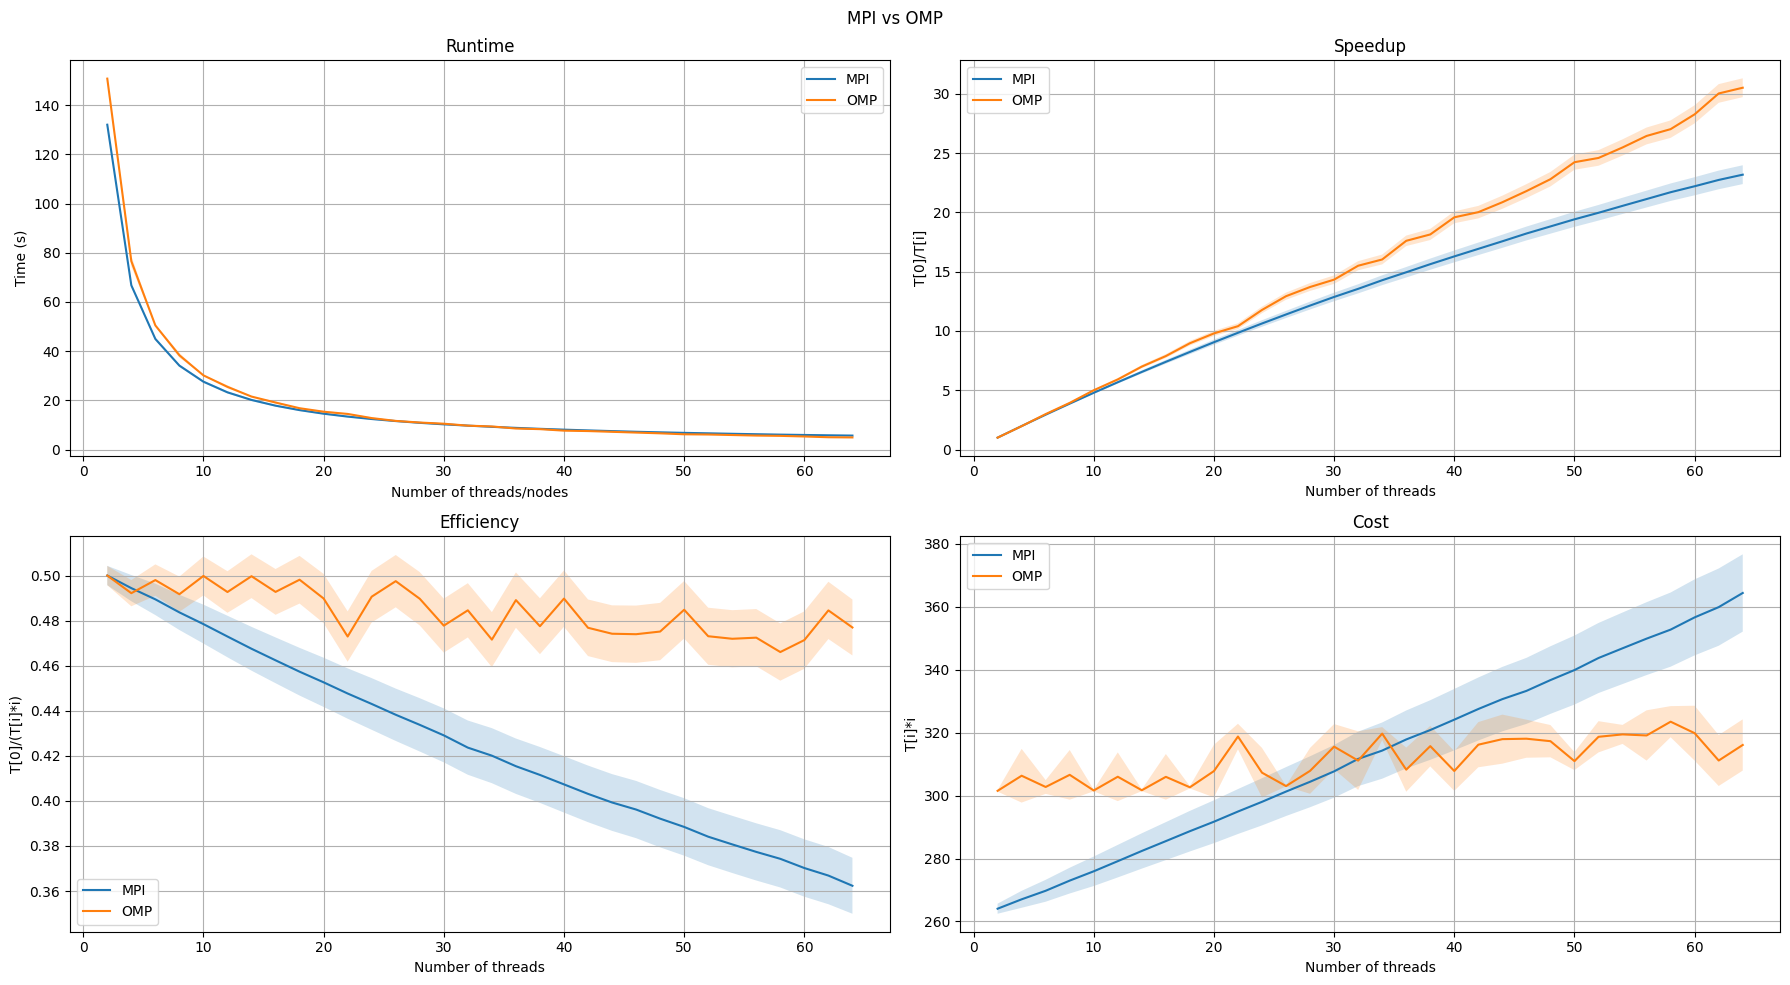

In [81]:
x_mpi, y_mpi, y_err_mpi = data_mpi()
x_omp, y_omp, y_err_omp = data_omp()

plot_data_2(x_mpi, y_mpi, y_err_mpi, x_omp, y_omp, y_err_omp, "MPI vs OMP", "MPI", "OMP")